In [1]:
import os
import cv2
import numpy as np
import glob
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns 

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `keras` framework.


# Reading the Data

In [6]:
# importing the tram_csv
tram_df = pd.read_csv('/Users/arasdirekoglu/Documents/Github/vegetation-detection-railways/aras/eda/tram_filenames.csv')
tram_df.drop(columns=tram_df.columns[0], axis=1, inplace=True)
tram_jpg = np.array(tram_df.filename_jpg)
tram_jpg

array(['rs02096.jpg', 'rs07844.jpg', 'rs06555.jpg', ..., 'rs08401.jpg',
       'rs06969.jpg', 'rs05051.jpg'], dtype=object)

In [7]:
len(tram_df.filename_mask.unique())

1290

In [169]:
path_masks = '/Users/arasdirekoglu/Documents/Studium/Master/HTW - MPMD/3. Semester/MPMD 3.1. PM & Data Analytics Lab/02_Project/00_data/rs19_val/uint8/rs19_val/rs02096.png'

In [159]:
tram_track=3 # 
rail_track=12
track_bed= 15
rail_raised= 17
rail_embedded =18

In [170]:
mask = Image.open(path_masks)
mask = mask.filter(ImageFilter.MedianFilter(size= 3))
mask = np.array(mask.resize((512,256),Image.NEAREST))
mask = np.expand_dims(mask, axis=2)
for i,val in enumerate(mask):
    for j,val1 in enumerate(val):
        if (val1==tram_track or val1==rail_track or val1==rail_embedded or val1==rail_raised or val1==track_bed):
            val[j] = 1
        else:
            val[j] = 0

/var/folders/bs/ht_t1wp94tl3wt5xhchcxq2m0000gn/T/ipykernel_57785/1106663954.py:3: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  mask = np.array(mask.resize((512,256),Image.NEAREST))


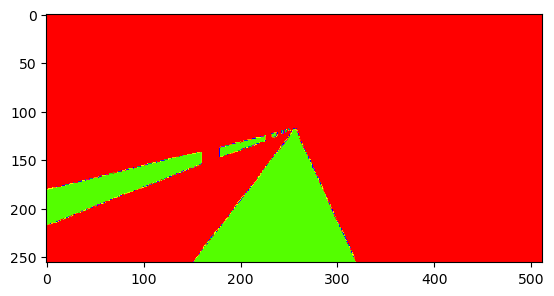

In [171]:
plt.imshow(mask, cmap='prism')

/var/folders/bs/ht_t1wp94tl3wt5xhchcxq2m0000gn/T/ipykernel_57785/4147985242.py:4: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image = np.array(image.resize((512, 256),Image.NEAREST))


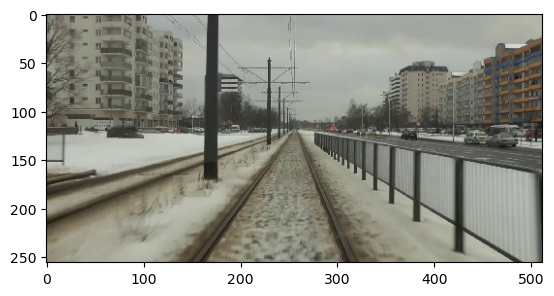

In [172]:
path_images = '/Users/arasdirekoglu/Documents/Studium/Master/HTW - MPMD/3. Semester/MPMD 3.1. PM & Data Analytics Lab/02_Project/00_data/rs19_val/jpgs/rs19_val/rs02096.jpg'
image = Image.open(path_images)
image = image.filter(ImageFilter.MedianFilter(size= 3))
image = np.array(image.resize((512, 256),Image.NEAREST))
plt.imshow(image)

In [154]:
# Setting up the directory for the files 
path_masks = '/Users/arasdirekoglu/Documents/Studium/Master/HTW - MPMD/3. Semester/MPMD 3.1. PM & Data Analytics Lab/02_Project/00_data/rs19_val/uint8/rs19_val/'
path_images = '/Users/arasdirekoglu/Documents/Studium/Master/HTW - MPMD/3. Semester/MPMD 3.1. PM & Data Analytics Lab/02_Project/00_data/rs19_val/jpgs/rs19_val/' 

# Setting up masks to determine ROI
tram_track=3 # 
rail_track=12
track_bed= 15
rail_raised= 17
rail_embedded =18

# Setting up empty lists for image & mask dataset 
image_dataset = []
mask_dataset = []

# Setting up the label of interest: 
label_of_interest = [17,18] #rail raised or embedded

# For loop 
for filename in os.listdir(path_images):
    if filename.endswith('.jpg') and filename in tram_jpg:
        image = Image.open(path_images+filename)
        image = image.filter(ImageFilter.MedianFilter(size= 3))
        image = np.array(image.resize((512, 256),Image.NEAREST))
        mask = Image.open(path_masks+filename[:7]+'.png')
        mask = mask.filter(ImageFilter.MedianFilter(size= 3))
        mask = np.array(mask.resize((512,256),Image.NEAREST))
        mask = np.expand_dims(mask, axis=2)
        for layer in range(len(mask[0,0,:])):
            mask[:,:,layer][mask[:,:,layer]==18 | mask[:,:,layer][mask[:,:,layer]==18]] = 1 
            mask[:,:,layer][mask[:,:,layer]!=18 | mask[:,:,layer][mask[:,:,layer]!=18]] = 0
        image_dataset.append(image)
        mask_dataset.append(mask)

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
mask_dataset = mask_dataset[:,:,:,0]
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

mask_dataset = np.expand_dims(mask_dataset, axis=3)
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

print('unique labels in mask', np.unique(mask_dataset))

/var/folders/bs/ht_t1wp94tl3wt5xhchcxq2m0000gn/T/ipykernel_57785/4036392431.py:20: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image = np.array(image.resize((512, 256),Image.NEAREST))
/var/folders/bs/ht_t1wp94tl3wt5xhchcxq2m0000gn/T/ipykernel_57785/4036392431.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  mask = np.array(mask.resize((512,256),Image.NEAREST))
/var/folders/bs/ht_t1wp94tl3wt5xhchcxq2m0000gn/T/ipykernel_57785/4036392431.py:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mask[:,:,layer][mask[:,:,layer]==18 | mask[:,:,layer][mask[:,:,layer]==18]] = 1
/var/folders/bs/ht_t1wp94tl3wt5xhchcxq2m0000gn/T/ipykernel_57785/4036392431.py:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mask[:,:,layer]

image:  (1290, 256, 512, 3)
mask:  (1290, 256, 512)
image:  (1290, 256, 512, 3)
mask:  (1290, 256, 512, 1)
unique labels in mask [0]


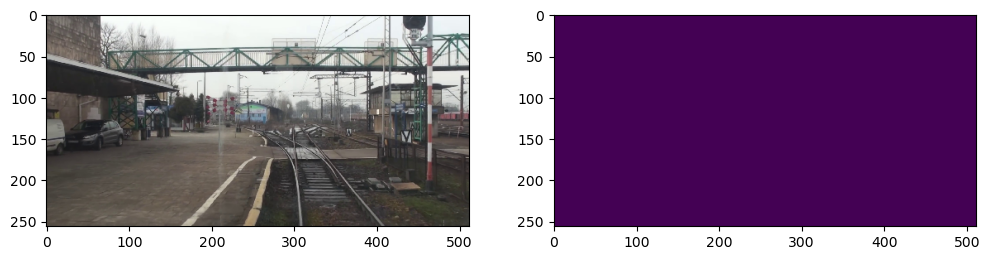

In [156]:
# Sanity check: Do images and masks match? 
image_number = np.random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()


# Split of Data

In [253]:
# split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


# Model

In [254]:
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [255]:
# define the model
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),'accuracy']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_54 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [256]:
history = model.fit(    X_train,
                        y_train,
                        batch_size=17,
                        epochs=15,
                        verbose=1,
                        validation_data=(X_test,y_test))

Epoch 1/15
62/62 [==============================] - 718s 12s/step - loss: 0.2202 - iou_score: 0.6209 - f1-score: 0.7569 - accuracy: 0.9219 - val_loss: 0.8038 - val_iou_score: 0.4930 - val_f1-score: 0.6587 - val_accuracy: 0.9025
Epoch 2/15
62/62 [==============================] - 709s 11s/step - loss: 0.1402 - iou_score: 0.7121 - f1-score: 0.8307 - accuracy: 0.9456 - val_loss: 0.2059 - val_iou_score: 0.6615 - val_f1-score: 0.7954 - val_accuracy: 0.9314
Epoch 3/15
62/62 [==============================] - 711s 11s/step - loss: 0.1241 - iou_score: 0.7361 - f1-score: 0.8468 - accuracy: 0.9509 - val_loss: 0.1690 - val_iou_score: 0.7084 - val_f1-score: 0.8286 - val_accuracy: 0.9407
Epoch 4/15
62/62 [==============================] - 718s 12s/step - loss: 0.1159 - iou_score: 0.7517 - f1-score: 0.8572 - accuracy: 0.9541 - val_loss: 0.1931 - val_iou_score: 0.7045 - val_f1-score: 0.8260 - val_accuracy: 0.9369
Epoch 5/15
62/62 [==============================] - 701s 11s/step - loss: 0.1042 - iou_s

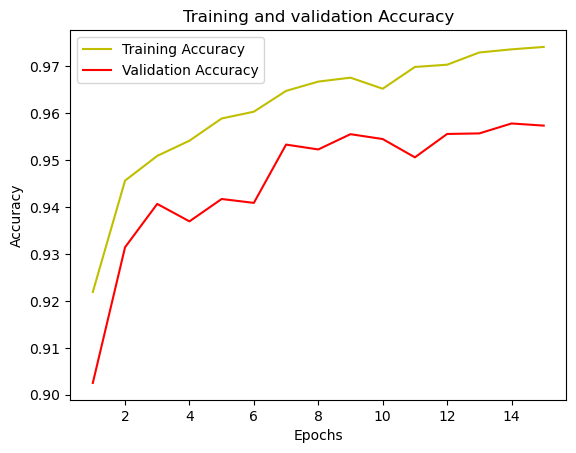

In [257]:
loss = history.history['loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

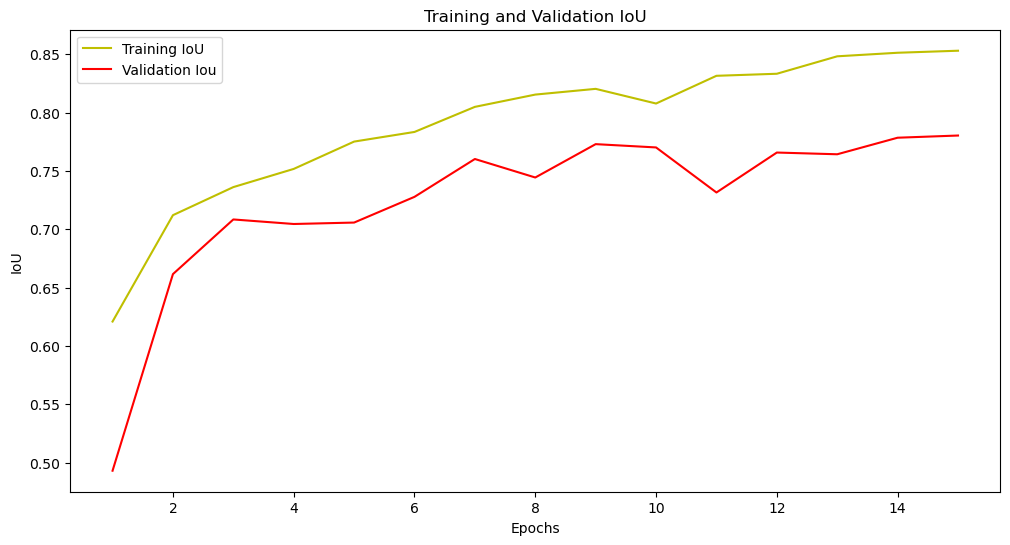

In [258]:
plt.figure(figsize=(12,6))
iou = history.history['iou_score']
vall_iou = history.history['val_iou_score']
epochs = range(1, len(iou) + 1)

plt.plot(epochs, iou, 'y', label='Training IoU')
plt.plot(epochs, vall_iou, 'r', label='Validation Iou')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [259]:
# function for triangle roi
def roi_triangle(predicted_img):
    width = predicted_img.shape[1]
    height = predicted_img.shape[0]
    roi = [
        (0, height),
        (width / 2, height / 2 ),
        (width, height)
    ]
    roi = np.array([roi], np.int32)
    predicted_img = np.ascontiguousarray(predicted_img, dtype=np.uint8)
    mask = np.zeros_like(predicted_img)
    #channel_count = 2
    match_mask_color = 255
    cv2.fillPoly(mask, (np.array([roi], np.int32)), match_mask_color)
    predicted_img = cv2.bitwise_and(predicted_img, mask)
    
    return predicted_img

1/1 [==============================] - 1s 690ms/step


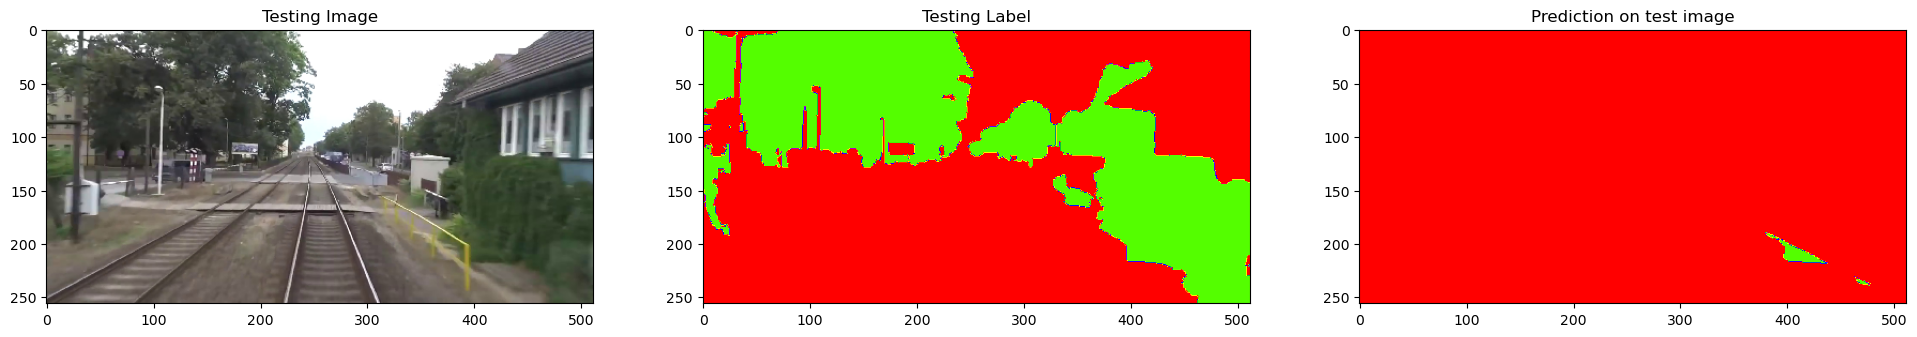

In [260]:
#test_img_number = np.random.randint(0, len(X_test))
test_img_number = 228
test_img = X_test[test_img_number]
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)#this is to make (256, 512, 1) -> (1, 256, 512, 1)
#test_img_input[:int(256/2),:,layer]=0
prediction = (model.predict(test_img_input))
my_threshold = 0.6
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis


#predicted_img[:int(256/2),:,layer]=0 # Use for half image 
predicted_img = roi_triangle(predicted_img) # Use this for triangle

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

In [261]:
# 6, 13, 228, rs230

/var/folders/bs/l4fdfr9d7td91bdr2lf6yx640000gn/T/ipykernel_38698/1135947348.py:3: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  rsimage = np.array(rsimage.resize((512, 256), Image.NEAREST))
/var/folders/bs/l4fdfr9d7td91bdr2lf6yx640000gn/T/ipykernel_38698/1135947348.py:8: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  rs_ground = np.array(rs_ground.resize((512, 256),Image.NEAREST))


1/1 [==============================] - 1s 527ms/step


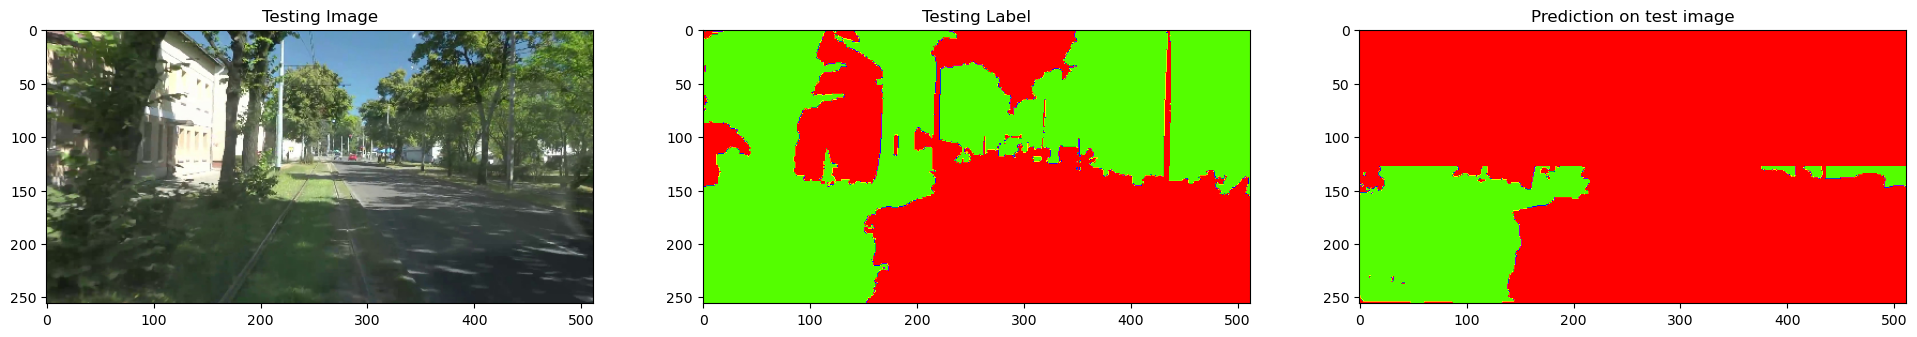

In [273]:
rsimage = Image.open(path_images+'rs00230.jpg')
rsimage = rsimage.filter(ImageFilter.MedianFilter(size=3))
rsimage = np.array(rsimage.resize((512, 256), Image.NEAREST))
rsimage_input=np.expand_dims(rsimage, 0)

rs_ground = Image.open(path_masks+'rs00230.png')
rs_ground = rs_ground.filter(ImageFilter.MedianFilter(size= 3))
rs_ground = np.array(rs_ground.resize((512, 256),Image.NEAREST))
rs_ground = np.expand_dims(rs_ground, axis=2)
for layer in range(len(rs_ground[0,0,:])):
    rs_ground[:,:,layer][rs_ground[:,:,layer]!=label_of_interest]=0
    rs_ground[:,:,layer][rs_ground[:,:,layer]==label_of_interest]=1

prediction = (model.predict(rsimage_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

predicted_img[:int(256/2),:,layer]=0 # Use this for half image 
#predicted_img = roi_triangle(predicted_img) # Use this for triangle

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(rsimage_input[0,:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(rs_ground[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

In [274]:
# Percentage Veg half image 
whole_roi = (predicted_img.shape[0] * predicted_img.shape[1])/2
veg = np.count_nonzero(predicted_img == 1)
veg_precent = (veg/whole_roi)*100
print(veg_precent)

31.37664794921875


In [272]:
# Percentage Veg roi triangle 
whole_roi = ((predicted_img.shape[0] * predicted_img.shape[1])/2)/2
veg = np.count_nonzero(predicted_img == 1)
veg_precent = (veg/whole_roi)*100
print(veg_precent)

15.7928466796875
